# Data Preparation

In [1]:
#import libraries
import tabulate
import pandas as pd
import seaborn as sns
import numpy as np

#preprocessing
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE, RandomOverSampler

#normalization
from sklearn import preprocessing

#classification
from interpret.glassbox import ExplainableBoostingClassifier
from sklearn.model_selection import cross_val_score, ShuffleSplit, cross_val_predict, KFold, cross_validate
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.pipeline import make_pipeline

import warnings
warnings.filterwarnings('ignore')

In [2]:
# bool columns in dataframe
global bool_columns
bool_columns = ['Smokes','Hormonal Contraceptives', 'IUD', 'STDs',
                'STDs:condylomatosis', 'STDs:cervical condylomatosis',
                'STDs:vaginal condylomatosis', 'STDs:vulvo-perineal condylomatosis',
                'STDs:syphilis', 'STDs:pelvic inflammatory disease', 
                'STDs:genital herpes', 'STDs:molluscum contagiosum',
                'STDs:AIDS', 'STDs:HIV', 'STDs:Hepatitis B', 'STDs:HPV',
                'Dx:Cancer', 'Dx:CIN', 'Dx:HPV', 'Dx']

# Function definitions
## Mean/mode imputation
Data imputation using mean/mode of columns
Following the methods described in: Razali et al. (2020).
Risk Factors of Cervical Cancer using Classification in Data Mining.
Journal of Physics: Conference Series. 1529. 022102. 10.1088/1742-6596/1529/2/022102.

Missing values for attribute that have integer data type were filled using the sample mean
while boolean were filled using the sample mode.

The mean/mode are calculated on the training set and the from fitting are saved and then used when predicting on the test set. 

In [3]:
def meanCalculation(df):
    mean_mode_dict={}
    # replace NaN with mode for columns with dtype bool
    for label, col in df.iteritems():
        if label in bool_columns:
            columns_mode = col.mode()
            df[label] = col.fillna(columns_mode[0])
            mean_mode_dict[label] = bool(columns_mode[0])

            #convert column to bool while we're at it
            df[label] = df[label].astype('bool')
        else:
            columns_mean = col.mean()
            df[label] = col.fillna(columns_mean) #[0]?
            mean_mode_dict[label] = columns_mean
        
    return df, mean_mode_dict

In [4]:
def meanImputation(df, mean_mode_dict={}):
    # replace NaN with mode for columns with dtype bool
    for label, col in df.iteritems():
        df[label] = col.fillna(mean_mode_dict[label])

    return df

**Custom transformer**

In [5]:
class MeanImputation(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        #Mean value calculation called on train set.
        X_ = X.copy() # create copy to avoid changes to original dataset
        [X_, mean_mode_dict_] = meanCalculation(X_)
        self.mean_mode_dict = mean_mode_dict_
        return self
    def transform(self, X):
        #Mean value imputation called on both sets using mean/mode from train set.
        X_ = X.copy() # create copy to avoid changes to original dataset
        X_ = meanImputation(X_, self.mean_mode_dict)
        return X_

# Preprocessing

**Loading Dataset**

In [6]:
# https://archive-beta.ics.uci.edu/ml/datasets/cervical+cancer+risk+factors
"""
The dataset was collected at 'Hospital Universitario de Caracas' in Caracas, Venezuela.
The dataset comprises demographic information, habits, and historic medical records of 858 patients.
Several patients decided not to answer some of the questions because of privacy concerns (missing values).
"""

rf = pd.read_csv('risk_factors_cervical_cancer.csv',encoding='utf8')
#rf.info()

**Covert data to usable datatypes**

In [7]:
# replace missing values with NaN
rf = rf.replace('?',np.nan)

# covert everything to float64, some classes will be converted to bool once missing values are taken care of
for label, col in rf.iteritems():
    rf[label] = pd.to_numeric(col, errors='coerce')

#TODO: some things are still int after this and object types get transformed to bool automatically. But NaN values
#are not falsly converted to True so that should be okay.

## Examine data

**Check missing values per column**

In [8]:
percent_missing = rf.isnull().sum() * 100 / len(rf)
missing_value_df = pd.DataFrame({'column_name': rf.columns,
                                 'percent_missing': percent_missing})

In [9]:
# remove columns with more than 20% missing
selection_columns = missing_value_df.loc[missing_value_df['percent_missing'] >= 20].iloc[:, 0]

for col in selection_columns:
    rf = rf.drop([col], axis=1)

**Check missing values per row**

In [10]:
missing_count = []
for idx in range(len(rf)):
    missing = rf.loc[[idx]].isna().sum().sum()
    missing_count.append(missing)

removed = 0
for idx, val in enumerate(missing_count):
    # Remove all rows where more than 15% of the data are missing
    # If 20% is chosen, 106 patients are excluded
    if val >= len(rf.columns)*0.15:
        rf = rf.drop(idx)
        removed+=1
print("{} number of rows were removed".format(removed))

106 number of rows were removed


**Investigate class imbalances**

In [11]:
# get number of patients per group
rf.groupby('Biopsy').count();

**Investigate STDs (number) vs STDs: Number of diagnosis**

In [12]:
# check if STDs (number) and STDs: Number of diagnosis are the same
STD_comparison = np.where((rf['STDs (number)']==rf['STDs: Number of diagnosis']), True, False)

# check manual calculation with STDs(number) if STDS (number) and STDs: Number of diagnosis not the same
if not STD_comparison.all():
    # create a new column with the sum of all STDs
    rf['STDs (number manual)'] = (rf['STDs:condylomatosis'] + rf['STDs:cervical condylomatosis'] +
        rf['STDs:vaginal condylomatosis'] + rf['STDs:vulvo-perineal condylomatosis'] +
        rf['STDs:syphilis'] + rf['STDs:pelvic inflammatory disease'] +
        rf['STDs:genital herpes'] + rf['STDs:molluscum contagiosum'] +
        rf['STDs:AIDS'] + rf['STDs:HIV'] +
        rf['STDs:Hepatitis B'] + rf['STDs:HPV'])
    
    # if they're the same drop the new column again
    manual_comp = np.where((rf['STDs (number)']==rf['STDs (number manual)']), True, False)
    if manual_comp.all():
        rf = rf.drop(['STDs (number manual)'], axis=1)

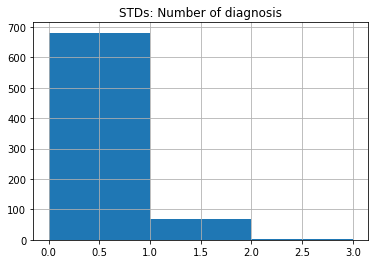

In [13]:
# STDs: Number of diagnosis is also not the same as just STDs
STD_comparison = np.where((rf['STDs']==rf['STDs: Number of diagnosis']), True, False).all() #=False

# is STDs: Number of diagnosis a encoded value?
minimum = rf['STDs: Number of diagnosis'].min() #=0
maximum = rf['STDs: Number of diagnosis'].max() #=3
# unlikely that it's the diagnosis code if the max is 3

# plot in histogram
ax = rf.hist(column=["STDs: Number of diagnosis"], bins=maximum)

# we don't know exactly what this column
# as our goal is to create a transparent model we decided to exclude the column
rf = rf.drop(['STDs: Number of diagnosis'], axis=1)

# Classification

**Explainable boosting classifier metrics**

**Pipelines with different oversampling and imputation methods**

In [14]:
# split dataset in features and target variable
feature_cols = rf.columns[0:len(rf.columns)-4]
X = rf[feature_cols] # Features
y = rf.Biopsy # Target variable

In [15]:
# set parameters for pipeline constructions

# parameters for SMOTE oversampling
# for reproducibility purposes
seed = 100
# SMOTE number of neighbors
k = 1

# defining unique imputer
unique_imputer = SimpleImputer(fill_value=-1 ,strategy='constant', add_indicator=True, copy=True)

# define SMOTE imputer
sm = SMOTE(sampling_strategy='auto', k_neighbors=k, random_state=seed)

# crossvalidation parameter
cv = None # default 5-fold cross validation

# define EBM model
# More information on EBMs can be found here: https://github.com/interpretml/interpret
# No interactions between features allowed to simplify explainability
ebm = ExplainableBoostingClassifier(interactions=0)

In [16]:
# pipeline 1 using unique value imputation and random oversampling
pipe_1 = make_pipeline(unique_imputer, RandomOverSampler('minority'), ebm)
scores_1 = cross_validate(pipe_1, X, y, cv=cv,scoring=['accuracy','roc_auc','f1', 'precision','recall'])
#scores_1

In [17]:
# pipeline 2 using mean/mode value imputation and random oversampling

pipe_2 = make_pipeline(MeanImputation(), RandomOverSampler('minority'), ebm)
scores_2 = cross_validate(pipe_2, X, y, cv=cv,scoring=['accuracy','roc_auc','f1', 'precision','recall'])
#scores_2

In [18]:
# pipeline 3 using unique value imputation and smote oversampling
pipe_3 = make_pipeline(unique_imputer, sm, ebm)
scores_3 = cross_validate(pipe_3, X, y, cv=cv, scoring=['accuracy','roc_auc','f1', 'precision','recall'])
#scores_3

In [19]:
# pipeline 4 using mean/mode imputation and smote oversampling
pipe_4 = make_pipeline(MeanImputation(), sm, ebm)
scores_4 = cross_validate(pipe_4, X, y, cv=cv, scoring=['accuracy','roc_auc','f1', 'precision','recall'])
#scores_4

**VISUALIZE RESULTS**

In [20]:
significant_numbers = 2 # used for rounding

combinations = [{'model':'EBM', 'sampling':'random', 'imputation':'unique', 'scores':scores_1},
                {'model':'EBM', 'sampling':'random', 'imputation':'mean/mode', 'scores':scores_2},
                {'model':'EBM', 'sampling':'SMOTE', 'imputation':'unique', 'scores':scores_3},
                {'model':'EBM', 'sampling':'SMOTE', 'imputation':'mean/mode', 'scores':scores_4}]

config_parameters = ['model', 'sampling', 'imputation']

headers = ["Model", "sampling", "imputation", "accuracy", "roc_auc", "f1", "precision", "recall"]
eval_metrics = ['test_accuracy', 'test_roc_auc', 'test_f1', 'test_precision', 'test_recall']

In [21]:
data = []
data.append(headers)

for combination in combinations:
    summary = [combination[param] for param in config_parameters]
    
    for metric in eval_metrics:
        mean = combination['scores'][metric].mean().round(significant_numbers)
        std = combination['scores'][metric].std().round(significant_numbers)
        summary.append(f'{mean} +- {std}')
        
    data.append(summary)
    
table = tabulate.tabulate(data, tablefmt='html')
table

Model,sampling,imputation,accuracy,roc_auc,f1,precision,recall
EBM,random,unique,0.8 +- 0.04,0.57 +- 0.03,0.17 +- 0.07,0.12 +- 0.05,0.3 +- 0.13
EBM,random,mean/mode,0.8 +- 0.05,0.57 +- 0.03,0.19 +- 0.07,0.13 +- 0.05,0.34 +- 0.13
EBM,SMOTE,unique,0.91 +- 0.03,0.59 +- 0.07,0.21 +- 0.17,0.44 +- 0.38,0.15 +- 0.12
EBM,SMOTE,mean/mode,0.88 +- 0.05,0.55 +- 0.06,0.17 +- 0.06,0.28 +- 0.18,0.15 +- 0.05
